In [14]:
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
class Dataset(torch.utils.data.Dataset):
    """
    overload dataset
    """

    def __init__ (self, x, y):
        self.x = x
        self.y = y
        # cast to float
        self.x = self.x.float()
        self.y = self.y.float()

    def __len__ (self): 
        return(len(self.y))

    def __getitem__ (self, idx):
        return self.x[idx], self.y[idx]

In [3]:
# load the data
data = torch.load('data/brain_cancer_dataset_small.pt')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
# split the data into training , validation and test sets
# in total we have 300 samples:
# 200 training samples
# 50 validation samples
# 50 test samples

# they are ordered, hence before splitting we shuffle the data
# torch.manual_seed(0)
# data = data[torch.randperm(len(data))]
# 
# # split the data
# train_data = data[:200]
# val_data = data[200:250]
# test_data = data[250:]

In [6]:
type(data)

__main__.Dataset

In [7]:
class brain_classifier(nn.Module):
    def __init__(self):
        super(brain_classifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 4 * 4, 10)  # Assuming input size is 32x32, adjust accordingly

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x
    
class minst_classifier(nn.Module):
    def __init__(self):
        super(minst_classifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size
        self.flatten_size = 64 * 3 * 3  # Adjusted from 4*4 to 3*3
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.flatten_size, 10)  # Adjust accordingly

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x

In [8]:
# class brain_classifier(nn.Module):
#     def __init__(self):
#         super(brain_classifier, self).__init__()
#         
#         # Define layers
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         
#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
#         
#         # Use a dummy input to infer the size of the fully connected layer
#         self.flatten = nn.Flatten()
#         
#         # Calculate the number of features after flattening
#         self._initialize_fc()
# 
#     def _initialize_fc(self):
#         with torch.no_grad():
#             dummy_input = torch.zeros(1, 1, 32, 32)
#             dummy_output = self.forward_conv(dummy_input)
#             num_features = dummy_output.shape[1]
#             self.fc = nn.Linear(num_features, 10)
# 
#     def forward_conv(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool1(x)
#         
#         x = F.relu(self.conv2(x))
#         x = self.pool2(x)
#         
#         x = F.relu(self.conv3(x))
#         x = self.pool3(x)
#         
#         x = self.flatten(x)
#         return x
#     
#     def forward(self, x):
#         x = self.forward_conv(x)
#         x = self.fc(x)
#         x = F.softmax(x, dim=1)
#         
#         return x

In [9]:
# Define the training loop
def train(model, train_data, val_data, epochs=10, lr=0.001):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Store the losses
    train_losses = []
    val_losses = []

    # Move model to the appropriate device
    model.to(device)

    for epoch in range(epochs):
        # Set the model to training mode
        model.train()

        # Iterate over the training data
        for i, (img, label) in enumerate(train_data):
            # Move data to the appropriate device
            img, label = img.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Compute the loss
            loss = criterion(y_pred, label)
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())
            # Print the loss
            if i % 10 == 0:
                print(f'Epoch {epoch}, Iteration {i}, Loss {loss.item()}')

        # Set the model to evaluation mode
        model.eval()
        # Compute the validation loss
        val_loss = 0
        with torch.no_grad():
            for img, label in val_data:
                # Move data to the appropriate device
                img, label = img.to(device), label.to(device)
                y_pred = model(img)
                loss = criterion(y_pred, label)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_data))

        print(f'Epoch {epoch}, Validation Loss {val_loss / len(val_data)}')

    return train_losses, val_losses


In [10]:

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to float32 and scales to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and std 0.5 (example values, adjust if needed)
])

# Load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# # Create data loaders
# train_loader = DataLoader(data, batch_size=32, shuffle=True)
# val_loader = DataLoader(data, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [11]:

# Example instantiation and training
model = minst_classifier()
train_losses, val_losses = train(model, train_loader, val_loader, epochs=10, lr=0.001)


Epoch 0, Iteration 0, Loss 2.3039963245391846
Epoch 0, Iteration 10, Loss 2.3024702072143555
Epoch 0, Iteration 20, Loss 2.298877239227295
Epoch 0, Iteration 30, Loss 2.255192756652832
Epoch 0, Iteration 40, Loss 2.145735740661621
Epoch 0, Iteration 50, Loss 1.984749436378479
Epoch 0, Iteration 60, Loss 1.801613211631775
Epoch 0, Iteration 70, Loss 1.7630040645599365
Epoch 0, Iteration 80, Loss 1.7539161443710327
Epoch 0, Iteration 90, Loss 1.7406013011932373
Epoch 0, Iteration 100, Loss 1.5774227380752563
Epoch 0, Iteration 110, Loss 1.5797288417816162
Epoch 0, Iteration 120, Loss 1.5584135055541992
Epoch 0, Iteration 130, Loss 1.5829966068267822
Epoch 0, Iteration 140, Loss 1.540050983428955
Epoch 0, Iteration 150, Loss 1.5812618732452393
Epoch 0, Iteration 160, Loss 1.5791095495224
Epoch 0, Iteration 170, Loss 1.566758394241333
Epoch 0, Iteration 180, Loss 1.6652019023895264
Epoch 0, Iteration 190, Loss 1.5915247201919556
Epoch 0, Iteration 200, Loss 1.5762304067611694
Epoch 0, Iter

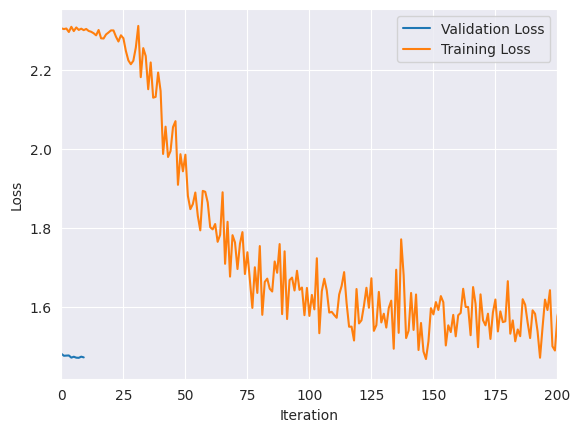

In [23]:
# plot the losses
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.xlim(0, 200)
plt.show()

In [24]:
# giusto pre vedere che cos'è il dataset usato

In [41]:
type(train_dataset)
train_dataset[0]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [48]:
# get the dtype of the data
train_dataset[0][0].dtype

torch.float32